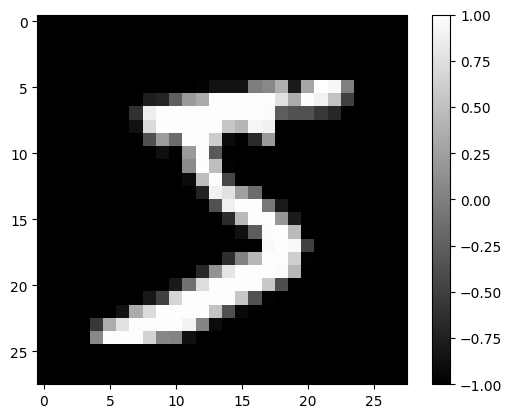

In [1]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
from torch import nn
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

preprocess = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)
batch_size = 128
dataset = MNIST(root='', train=True, download=True, transform=preprocess)
loader_train = DataLoader(dataset, batch_size, shuffle=True)
plt.imshow(dataset[0][0].squeeze(), cmap='gray')
plt.colorbar()
plt.show()

Input shape: torch.Size([1, 1, 28, 28])
Output shape: torch.Size([1, 1, 28, 28])


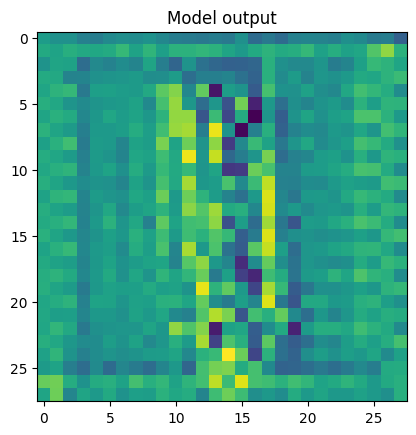

In [2]:
from unet import UNet

model = UNet(in_channels=1, out_channels=1, block_out_channels=[64, 128],)

sample_image = dataset[8][0].unsqueeze(0)
print("Input shape:", sample_image.shape)

print("Output shape:", model(sample_image, torch.ones(1)).shape)
plt.imshow(model(sample_image, torch.ones(1)).squeeze().detach().numpy())
plt.title("Model output")
plt.show()

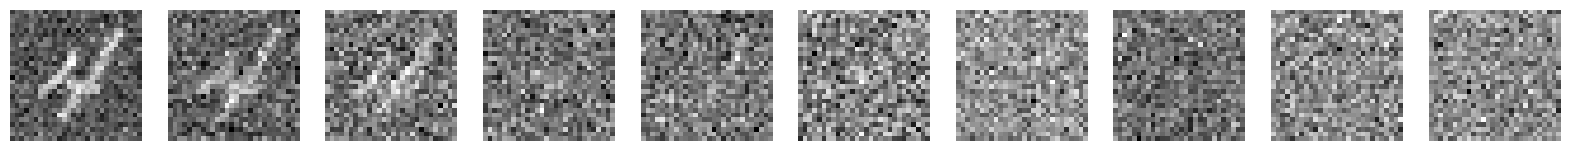

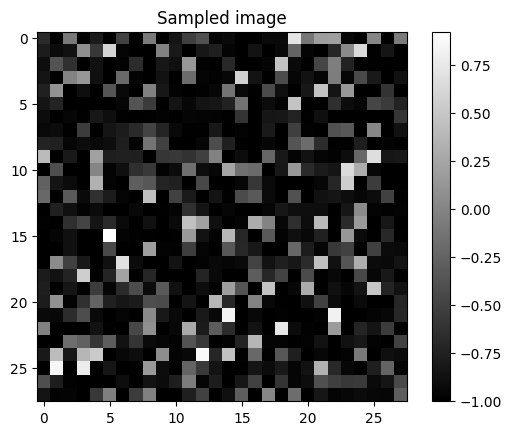

In [3]:
from ddpm import DDPM
        
        
    
model = DDPM(in_channels=1, out_channels=1, block_out_channels=[64, 128], device=device)
model.to(device)
sample_image = dataset[9][0].unsqueeze(0).to(device)
noised_image, noise = model(sample_image, 1)
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i,t in enumerate([99, 199, 299, 399, 499, 599, 699, 799, 899, 999]):
    noised_image = model(sample_image, t)
    axes[i].imshow(noised_image[0].squeeze().detach().cpu().numpy(), cmap='gray')
    axes[i].axis('off')

output = model.sampling(1000)
plt.figure()
plt.imshow(output.squeeze().detach().cpu().numpy(), cmap='gray')
plt.colorbar()
plt.title("Sampled image")
plt.show()

469it [00:17, 27.42it/s]


Epoch: 0, Loss: 0.8526409864425659


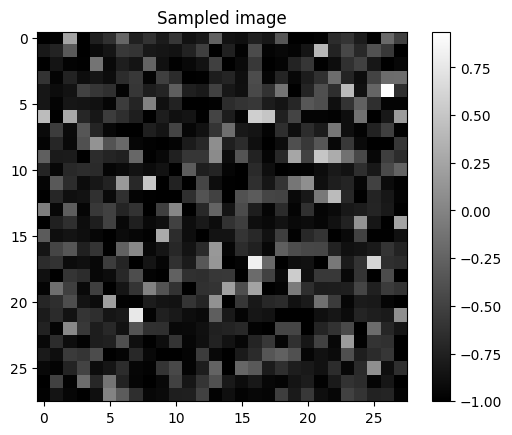

469it [00:16, 28.16it/s]


Epoch: 1, Loss: 0.7481315732002258


469it [00:16, 28.21it/s]


Epoch: 2, Loss: 0.6848613023757935


469it [00:17, 27.34it/s]


Epoch: 3, Loss: 0.6355156302452087


469it [00:16, 28.30it/s]


Epoch: 4, Loss: 0.5925644636154175


469it [00:16, 28.16it/s]


Epoch: 5, Loss: 0.564136803150177


469it [00:16, 28.16it/s]


Epoch: 6, Loss: 0.5238102674484253


469it [00:16, 28.10it/s]


Epoch: 7, Loss: 0.500339925289154


469it [00:16, 28.20it/s]


Epoch: 8, Loss: 0.47618475556373596


469it [00:16, 28.07it/s]


Epoch: 9, Loss: 0.4696572721004486


469it [00:16, 28.24it/s]


Epoch: 10, Loss: 0.4496847093105316


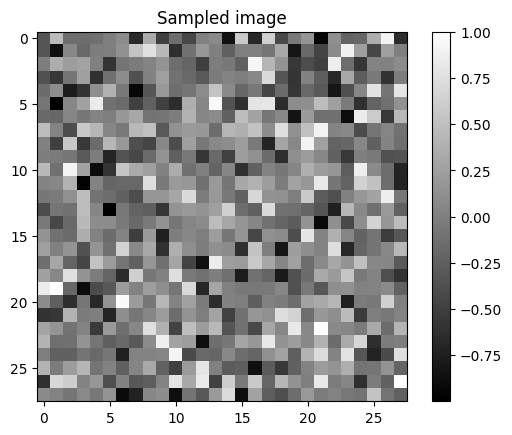

469it [00:16, 27.62it/s]


Epoch: 11, Loss: 0.42660075426101685


469it [00:17, 27.31it/s]


Epoch: 12, Loss: 0.43873366713523865


469it [00:16, 27.71it/s]


Epoch: 13, Loss: 0.3932649791240692


469it [00:16, 27.74it/s]


Epoch: 14, Loss: 0.40817317366600037


469it [00:16, 27.66it/s]


Epoch: 15, Loss: 0.3972111940383911


469it [00:16, 27.77it/s]


Epoch: 16, Loss: 0.3632098138332367


469it [00:16, 27.72it/s]


Epoch: 17, Loss: 0.3492325246334076


469it [00:16, 27.62it/s]


Epoch: 18, Loss: 0.3216789662837982


469it [00:17, 27.53it/s]


Epoch: 19, Loss: 0.31372618675231934


469it [00:17, 27.48it/s]


Epoch: 20, Loss: 0.30045270919799805


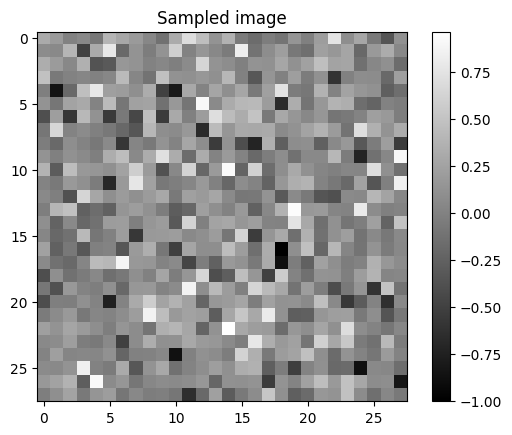

469it [00:17, 27.12it/s]


Epoch: 21, Loss: 0.3032044470310211


469it [00:17, 27.29it/s]


Epoch: 22, Loss: 0.2735030949115753


469it [00:17, 27.22it/s]


Epoch: 23, Loss: 0.26560699939727783


469it [00:17, 27.15it/s]


Epoch: 24, Loss: 0.26042231917381287


469it [00:17, 27.34it/s]


Epoch: 25, Loss: 0.2641833424568176


469it [00:17, 27.41it/s]


Epoch: 26, Loss: 0.25968021154403687


469it [00:17, 27.47it/s]


Epoch: 27, Loss: 0.2192990481853485


469it [00:17, 27.28it/s]


Epoch: 28, Loss: 0.23576821386814117


469it [00:17, 27.33it/s]


Epoch: 29, Loss: 0.2022847980260849


469it [00:17, 27.34it/s]


Epoch: 30, Loss: 0.1911555379629135


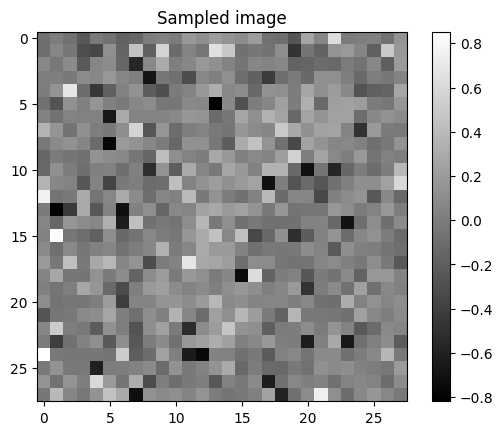

469it [00:17, 27.23it/s]


Epoch: 31, Loss: 0.18376873433589935


469it [00:17, 27.35it/s]


Epoch: 32, Loss: 0.17597486078739166


469it [00:17, 27.45it/s]


Epoch: 33, Loss: 0.16372157633304596


469it [00:16, 27.63it/s]


Epoch: 34, Loss: 0.15759743750095367


469it [00:17, 27.47it/s]


Epoch: 35, Loss: 0.1592719703912735


469it [00:17, 27.43it/s]


Epoch: 36, Loss: 0.1413758248090744


469it [00:17, 27.39it/s]


Epoch: 37, Loss: 0.14448583126068115


469it [00:17, 27.51it/s]


Epoch: 38, Loss: 0.1307573914527893


469it [00:17, 27.46it/s]


Epoch: 39, Loss: 0.1323724091053009


469it [00:17, 27.44it/s]


Epoch: 40, Loss: 0.13300146162509918


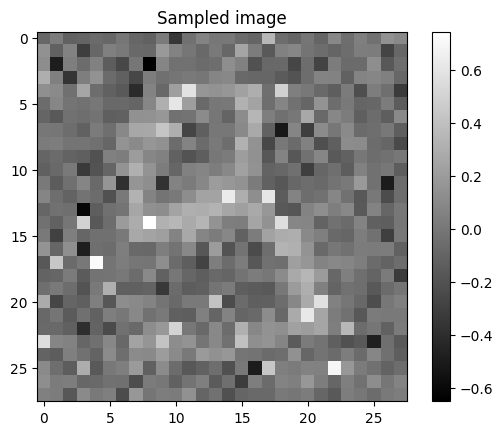

469it [00:17, 27.21it/s]


Epoch: 41, Loss: 0.11942841112613678


469it [00:17, 27.19it/s]


Epoch: 42, Loss: 0.11994703114032745


469it [00:17, 27.43it/s]


Epoch: 43, Loss: 0.12291380017995834


469it [00:17, 27.29it/s]


Epoch: 44, Loss: 0.136763334274292


469it [00:17, 27.17it/s]


Epoch: 45, Loss: 0.11818186193704605


469it [00:17, 27.24it/s]


Epoch: 46, Loss: 0.09320037811994553


469it [00:17, 27.14it/s]


Epoch: 47, Loss: 0.08621399104595184


469it [00:17, 27.19it/s]


Epoch: 48, Loss: 0.087445929646492


469it [00:17, 27.32it/s]


Epoch: 49, Loss: 0.0765167698264122


469it [00:17, 27.19it/s]


Epoch: 50, Loss: 0.10748620331287384


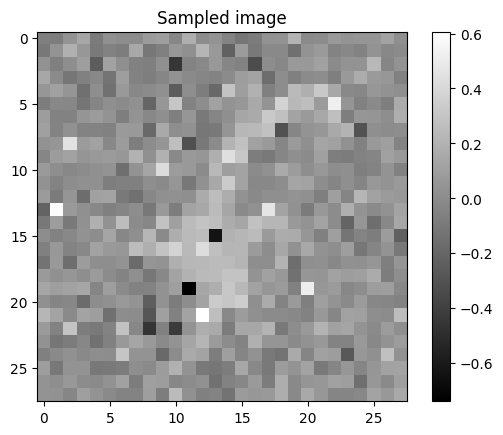

469it [00:18, 25.37it/s]


Epoch: 51, Loss: 0.08927689492702484


469it [00:18, 25.37it/s]


Epoch: 52, Loss: 0.06551803648471832


469it [00:18, 25.38it/s]


Epoch: 53, Loss: 0.06524327397346497


469it [00:18, 25.36it/s]


Epoch: 54, Loss: 0.058913521468639374


469it [00:18, 25.37it/s]


Epoch: 55, Loss: 0.059032704681158066


469it [00:18, 25.37it/s]


Epoch: 56, Loss: 0.09586937725543976


469it [00:18, 25.36it/s]


Epoch: 57, Loss: 0.06610018759965897


469it [00:18, 25.45it/s]


Epoch: 58, Loss: 0.06838817894458771


469it [00:18, 25.32it/s]


Epoch: 59, Loss: 0.04668718948960304


469it [00:18, 25.18it/s]


Epoch: 60, Loss: 0.06373210996389389


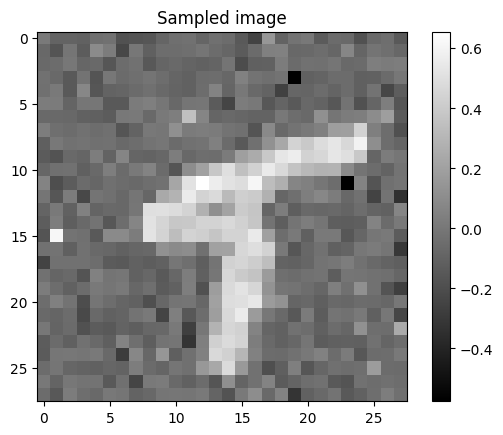

469it [00:17, 27.05it/s]


Epoch: 61, Loss: 0.042227309197187424


469it [00:17, 27.31it/s]


Epoch: 62, Loss: 0.0629444345831871


469it [00:17, 27.23it/s]


Epoch: 63, Loss: 0.10746141523122787


469it [00:17, 27.20it/s]


Epoch: 64, Loss: 0.035087719559669495


469it [00:17, 27.07it/s]


Epoch: 65, Loss: 0.03307807072997093


469it [00:17, 27.19it/s]


Epoch: 66, Loss: 0.0704999640583992


469it [00:17, 27.25it/s]


Epoch: 67, Loss: 0.03022466041147709


469it [00:17, 27.03it/s]


Epoch: 68, Loss: 0.034068215638399124


469it [00:17, 26.89it/s]


Epoch: 69, Loss: 0.027504388242959976


469it [00:17, 27.00it/s]


Epoch: 70, Loss: 0.043247539550065994


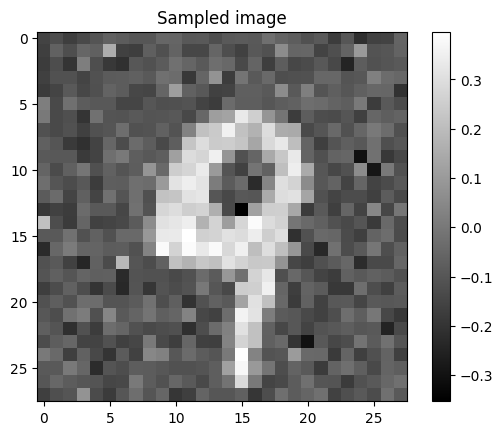

469it [00:18, 25.62it/s]


Epoch: 71, Loss: 0.024629240855574608


469it [00:18, 25.51it/s]


Epoch: 72, Loss: 0.023381361737847328


469it [00:18, 25.38it/s]


Epoch: 73, Loss: 0.028481528162956238


469it [00:18, 25.43it/s]


Epoch: 74, Loss: 0.02663472481071949


469it [00:18, 25.46it/s]


Epoch: 75, Loss: 0.019357914105057716


469it [00:18, 25.38it/s]


Epoch: 76, Loss: 0.04954605922102928


469it [00:18, 25.41it/s]


Epoch: 77, Loss: 0.017906315624713898


469it [00:18, 25.58it/s]


Epoch: 78, Loss: 0.03747734799981117


469it [00:18, 25.54it/s]


Epoch: 79, Loss: 0.12364313006401062


469it [00:18, 25.56it/s]


Epoch: 80, Loss: 0.02503841184079647


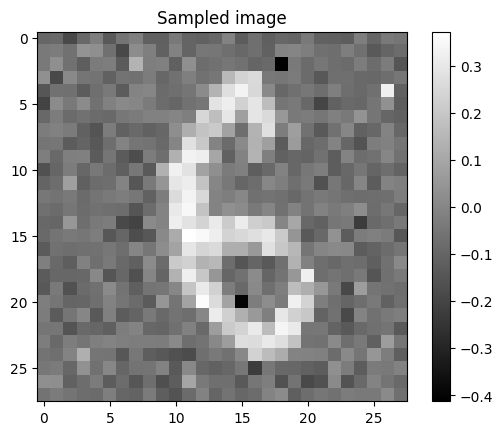

469it [00:18, 25.56it/s]


Epoch: 81, Loss: 0.04017019644379616


469it [00:18, 25.42it/s]


Epoch: 82, Loss: 0.013183396309614182


469it [00:18, 25.48it/s]


Epoch: 83, Loss: 0.053772538900375366


469it [00:18, 25.51it/s]


Epoch: 84, Loss: 0.015102467499673367


469it [00:18, 25.43it/s]


Epoch: 85, Loss: 0.0314110703766346


469it [00:18, 25.54it/s]


Epoch: 86, Loss: 0.04326499626040459


469it [00:18, 25.50it/s]


Epoch: 87, Loss: 0.010422698222100735


469it [00:18, 25.47it/s]


Epoch: 88, Loss: 0.011314612813293934


469it [00:18, 25.48it/s]


Epoch: 89, Loss: 0.03296281024813652


469it [00:18, 25.48it/s]


Epoch: 90, Loss: 0.046806029975414276


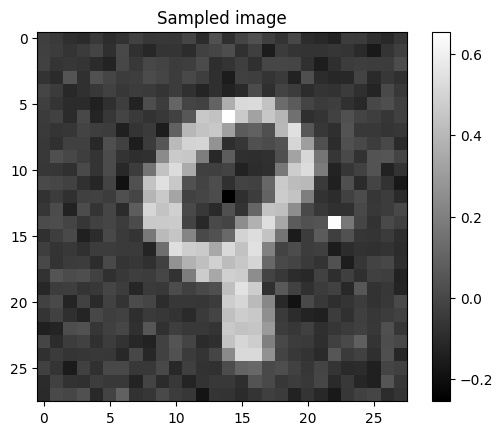

469it [00:17, 27.47it/s]


Epoch: 91, Loss: 0.016675040125846863


469it [00:17, 27.32it/s]


Epoch: 92, Loss: 0.07798531651496887


469it [00:17, 27.34it/s]


Epoch: 93, Loss: 0.007624382618814707


469it [00:17, 27.10it/s]


Epoch: 94, Loss: 0.03207828849554062


469it [00:17, 27.16it/s]


Epoch: 95, Loss: 0.01285367738455534


469it [00:17, 27.20it/s]


Epoch: 96, Loss: 0.00631840992718935


469it [00:17, 27.18it/s]


Epoch: 97, Loss: 0.011074055917561054


469it [00:17, 27.19it/s]


Epoch: 98, Loss: 0.056961990892887115


469it [00:17, 27.05it/s]


Epoch: 99, Loss: 0.007125364616513252


469it [00:17, 27.19it/s]


Epoch: 100, Loss: 0.00506375078111887


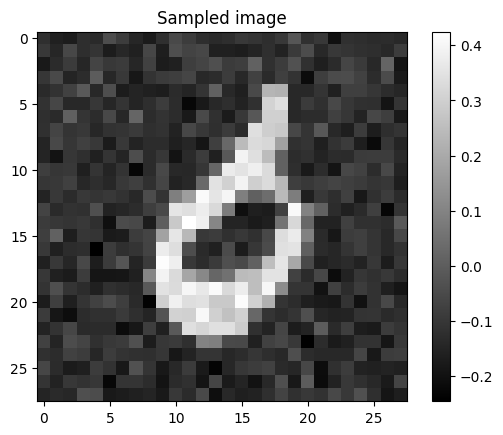

469it [00:17, 27.48it/s]


Epoch: 101, Loss: 0.024043725803494453


469it [00:16, 27.65it/s]


Epoch: 102, Loss: 0.02810426615178585


469it [00:16, 27.59it/s]


Epoch: 103, Loss: 0.004692868795245886


469it [00:16, 27.62it/s]


Epoch: 104, Loss: 0.02055945247411728


469it [00:17, 27.51it/s]


Epoch: 105, Loss: 0.03521718084812164


469it [00:16, 27.69it/s]


Epoch: 106, Loss: 0.03724502772092819


469it [00:16, 27.63it/s]


Epoch: 107, Loss: 0.020023342221975327


469it [00:16, 27.61it/s]


Epoch: 108, Loss: 0.0055539170280098915


469it [00:17, 27.56it/s]


Epoch: 109, Loss: 0.010525945574045181


469it [00:16, 27.60it/s]


Epoch: 110, Loss: 0.0036475276574492455


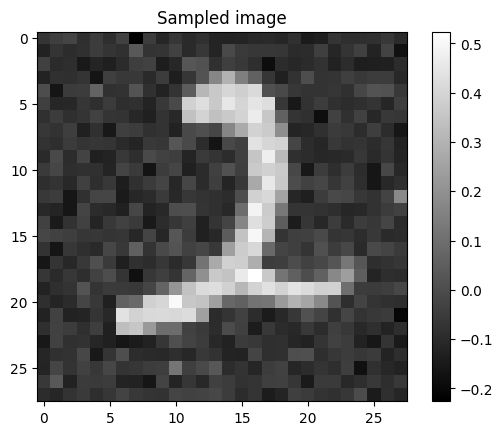

469it [00:17, 27.28it/s]


Epoch: 111, Loss: 0.0046180617064237595


469it [00:17, 27.14it/s]


Epoch: 112, Loss: 0.03708202391862869


469it [00:17, 27.07it/s]


Epoch: 113, Loss: 0.014489825814962387


469it [00:17, 27.20it/s]


Epoch: 114, Loss: 0.018689626827836037


469it [00:17, 27.04it/s]


Epoch: 115, Loss: 0.018163496628403664


469it [00:17, 27.09it/s]


Epoch: 116, Loss: 0.0027831261977553368


469it [00:17, 27.08it/s]


Epoch: 117, Loss: 0.0029395155142992735


469it [00:17, 27.11it/s]


Epoch: 118, Loss: 0.006729195360094309


469it [00:17, 27.06it/s]


Epoch: 119, Loss: 0.0028628804720938206


469it [00:17, 27.02it/s]


Epoch: 120, Loss: 0.0050253248773515224


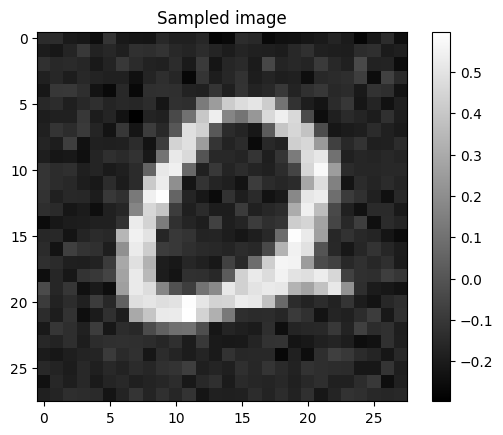

469it [00:18, 25.76it/s]


Epoch: 121, Loss: 0.0049886382184922695


469it [00:18, 25.75it/s]


Epoch: 122, Loss: 0.0033779351506382227


469it [00:18, 25.72it/s]


Epoch: 123, Loss: 0.04166591912508011


469it [00:18, 25.86it/s]


Epoch: 124, Loss: 0.029443422332406044


469it [00:18, 25.75it/s]


Epoch: 125, Loss: 0.021878857165575027


469it [00:18, 25.78it/s]


Epoch: 126, Loss: 0.001977508421987295


469it [00:18, 25.75it/s]


Epoch: 127, Loss: 0.001985963201150298


469it [00:18, 25.64it/s]


Epoch: 128, Loss: 0.0653892233967781


469it [00:18, 25.66it/s]


Epoch: 129, Loss: 0.0034384187310934067


469it [00:18, 25.68it/s]


Epoch: 130, Loss: 0.0019725302699953318


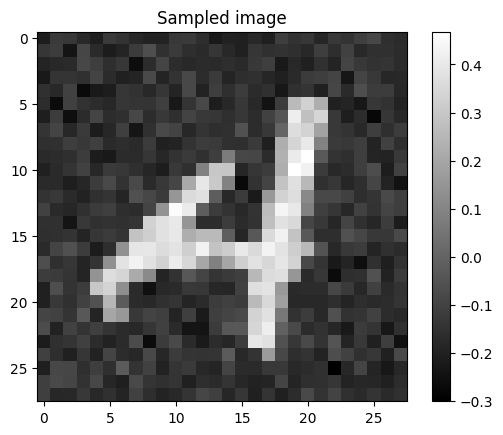

469it [00:17, 27.39it/s]


Epoch: 131, Loss: 0.08595649152994156


469it [00:17, 27.43it/s]


Epoch: 132, Loss: 0.0017952886410057545


469it [00:17, 27.42it/s]


Epoch: 133, Loss: 0.015546766109764576


469it [00:17, 27.35it/s]


Epoch: 134, Loss: 0.0018938897410407662


469it [00:17, 27.42it/s]


Epoch: 135, Loss: 0.0018682564841583371


469it [00:17, 27.47it/s]


Epoch: 136, Loss: 0.023215401917696


469it [00:17, 27.48it/s]


Epoch: 137, Loss: 0.0026928919833153486


469it [00:17, 27.33it/s]


Epoch: 138, Loss: 0.003406808478757739


469it [00:17, 27.42it/s]


Epoch: 139, Loss: 0.01982228271663189


469it [00:17, 27.33it/s]


Epoch: 140, Loss: 0.009659732691943645


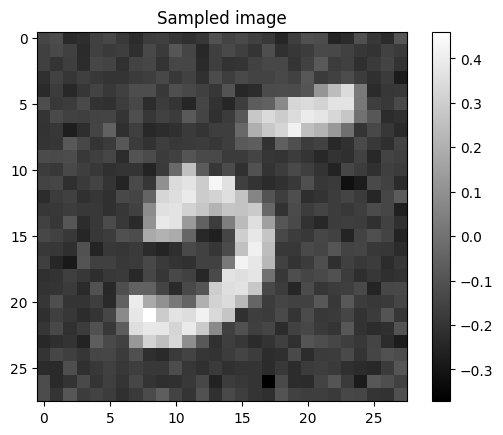

469it [00:16, 27.69it/s]


Epoch: 141, Loss: 0.1054997593164444


469it [00:16, 27.70it/s]


Epoch: 142, Loss: 0.0016398853622376919


469it [00:17, 27.55it/s]


Epoch: 143, Loss: 0.01780754141509533


469it [00:16, 27.81it/s]


Epoch: 144, Loss: 0.03432570397853851


469it [00:16, 27.82it/s]


Epoch: 145, Loss: 0.02807784453034401


469it [00:16, 27.77it/s]


Epoch: 146, Loss: 0.06887386739253998


469it [00:16, 27.72it/s]


Epoch: 147, Loss: 0.007928191684186459


469it [00:16, 27.73it/s]


Epoch: 148, Loss: 0.03096437081694603


469it [00:16, 27.77it/s]


Epoch: 149, Loss: 0.006009008269757032


469it [00:16, 27.74it/s]


Epoch: 150, Loss: 0.022081654518842697


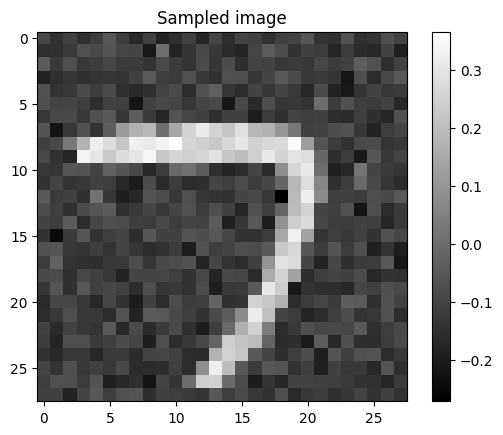

469it [00:18, 25.15it/s]


Epoch: 151, Loss: 0.003897890681400895


469it [00:18, 25.04it/s]


Epoch: 152, Loss: 0.022567126899957657


469it [00:18, 25.04it/s]


Epoch: 153, Loss: 0.0013238608371466398


469it [00:18, 25.12it/s]


Epoch: 154, Loss: 0.0016546648694202304


469it [00:18, 25.04it/s]


Epoch: 155, Loss: 0.0013567954301834106


469it [00:18, 25.06it/s]


Epoch: 156, Loss: 0.024294132366776466


469it [00:18, 25.10it/s]


Epoch: 157, Loss: 0.02634168043732643


469it [00:18, 25.05it/s]


Epoch: 158, Loss: 0.00361132575199008


469it [00:18, 25.00it/s]


Epoch: 159, Loss: 0.002796377055346966


469it [00:18, 25.12it/s]


Epoch: 160, Loss: 0.03258209675550461


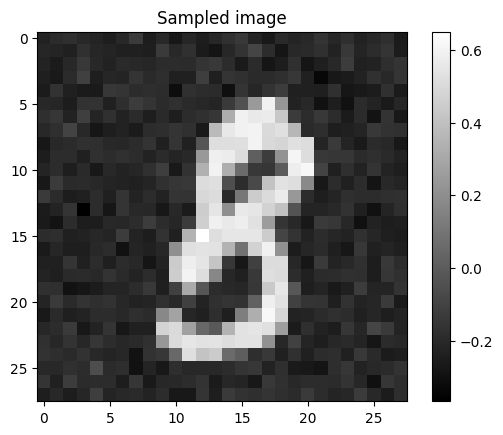

469it [00:16, 27.82it/s]


Epoch: 161, Loss: 0.025981979444622993


469it [00:16, 27.74it/s]


Epoch: 162, Loss: 0.03388924524188042


469it [00:16, 27.81it/s]


Epoch: 163, Loss: 0.05019791051745415


469it [00:16, 27.76it/s]


Epoch: 164, Loss: 0.0011628713691607118


469it [00:16, 27.82it/s]


Epoch: 165, Loss: 0.04778342321515083


469it [00:16, 27.85it/s]


Epoch: 166, Loss: 0.013247495517134666


469it [00:16, 27.89it/s]


Epoch: 167, Loss: 0.0018541879253461957


469it [00:16, 27.83it/s]


Epoch: 168, Loss: 0.0021352600306272507


469it [00:16, 27.74it/s]


Epoch: 169, Loss: 0.021892769262194633


469it [00:16, 27.83it/s]


Epoch: 170, Loss: 0.0010120602091774344


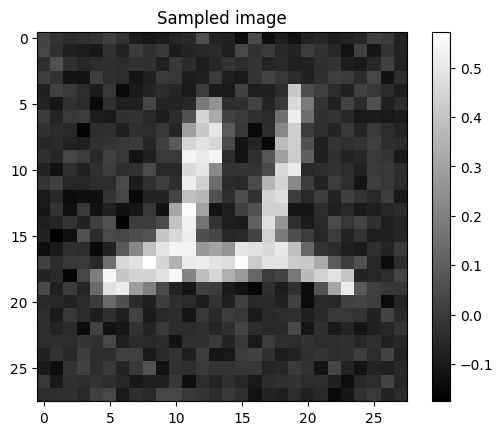

469it [00:17, 27.22it/s]


Epoch: 171, Loss: 0.0026849224232137203


469it [00:17, 27.35it/s]


Epoch: 172, Loss: 0.0363057442009449


469it [00:17, 27.37it/s]


Epoch: 173, Loss: 0.031556520611047745


469it [00:17, 27.24it/s]


Epoch: 174, Loss: 0.024289967492222786


469it [00:17, 27.14it/s]


Epoch: 175, Loss: 0.001434466801583767


469it [00:17, 27.30it/s]


Epoch: 176, Loss: 0.000919034646358341


469it [00:17, 27.28it/s]


Epoch: 177, Loss: 0.003994831349700689


469it [00:17, 27.39it/s]


Epoch: 178, Loss: 0.00649480102583766


469it [00:17, 27.35it/s]


Epoch: 179, Loss: 0.0022647457662969828


469it [00:17, 27.14it/s]


Epoch: 180, Loss: 0.031820446252822876


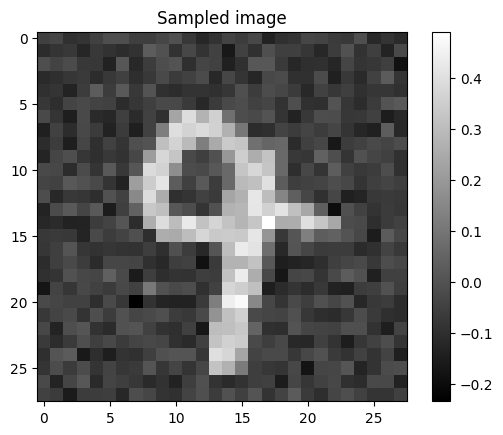

469it [00:17, 26.48it/s]


Epoch: 181, Loss: 0.0008958951220847666


469it [00:17, 26.44it/s]


Epoch: 182, Loss: 0.022501669824123383


469it [00:17, 26.42it/s]


Epoch: 183, Loss: 0.05778016895055771


469it [00:17, 26.59it/s]


Epoch: 184, Loss: 0.009149705059826374


469it [00:17, 26.40it/s]


Epoch: 185, Loss: 0.0008516299421899021


469it [00:17, 26.41it/s]


Epoch: 186, Loss: 0.028714552521705627


469it [00:17, 26.54it/s]


Epoch: 187, Loss: 0.01771664433181286


469it [00:17, 26.44it/s]


Epoch: 188, Loss: 0.026284676045179367


469it [00:17, 26.37it/s]


Epoch: 189, Loss: 0.0036343943793326616


469it [00:17, 26.50it/s]


Epoch: 190, Loss: 0.04313451796770096


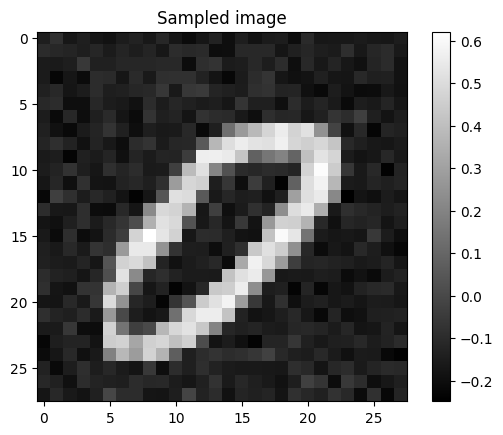

469it [00:17, 27.41it/s]


Epoch: 191, Loss: 0.022578995674848557


469it [00:17, 27.24it/s]


Epoch: 192, Loss: 0.007101057097315788


469it [00:17, 27.10it/s]


Epoch: 193, Loss: 0.0007940137293189764


469it [00:17, 27.06it/s]


Epoch: 194, Loss: 0.0011789565905928612


469it [00:17, 26.99it/s]


Epoch: 195, Loss: 0.03676438704133034


469it [00:17, 27.22it/s]


Epoch: 196, Loss: 0.00225913361646235


469it [00:17, 27.25it/s]


Epoch: 197, Loss: 0.0008039610111154616


469it [00:17, 27.30it/s]


Epoch: 198, Loss: 0.009903356432914734


469it [00:17, 27.17it/s]


Epoch: 199, Loss: 0.09198945760726929


In [4]:
from random import randint
from tqdm import tqdm

def training(model, epochs, criterion, optimizer, loader_train, T = 1000):
    '''Training loop for the model.
    model: model to be trained.
    lr: learning rate.
    epochs: number of epochs.
    criterion: loss function.
    optimizer: optimizer to be used.
    loader_train: training data loader.'''
    model.train()
    for epoch in range(epochs):
        for i, (images, _) in tqdm(enumerate(loader_train)):
            images = images.to(device)
            t = randint(0, T-1)
            x_noised, noise = model.forward(images, t)
            optimizer.zero_grad()
            
            noise_pred = model.model(x_noised, t)
            loss = criterion(noise_pred, noise)
            loss.backward()
            optimizer.step()
        print(f"Epoch: {epoch}, Loss: {loss.item()}")
        if epoch % 10 == 0:
            img = model.sampling(T)
            plt.imshow(img.squeeze().detach().cpu().numpy(), cmap='gray')
            plt.colorbar()
            plt.title("Sampled image")
            plt.show()
    return model

lr = 1e-4
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs = 200
model = training(model, epochs, criterion, optimizer, loader_train)


In [ ]:
torch.save(model.state_dict(), 'model.pth')